In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




<b>While pre-processing the original dataset we have taken into consideration the following points.</b>

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

In [14]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from wordcloud import WordCloud

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [15]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('../input/amazon-fine-food-reviews/database.sqlite') 

#Filter only positive and negative reviews. Do not consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display some of the datapoints from the loaded dataset.
print("Number of data points in our data", filtered_data.shape[0])
print("Number of features in our data", filtered_data.shape[1])
filtered_data.head(5)

Number of data points in our data 525814
Number of features in our data 12


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [16]:
#This code block check how many entries are there from the same user id, who has provided review more than one time for different products.
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", connection_sqlobject)

print(display.shape)
display.head()


(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [17]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [18]:
display['COUNT(*)'].sum()

393063

In [19]:
#Checking the number of entries that came from UserId="AR5J8UI46CURR"
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", connection_sqlobject)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [20]:
#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64


In [21]:
#Sorting data according to Time in ascending order. The oldest reviews will be displayed at the top and the new reviews will be display at the end of the dataset.
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [22]:
#Removing duplicate entries based on past knowledge.
filtered_duplicates=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the data matrix after deduplication, Stage 1: {}".format(filtered_duplicates.shape))


The shape of the data matrix after deduplication, Stage 1: (364173, 12)


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [23]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection_sqlobject)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [24]:
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

In [25]:
#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication, Stage 2: : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Delete unwanted variables to free up memory space
del(filtered_duplicates, filtered_data, display, sorted_data)

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)


The shape of the data matrix after deduplication, Stage 2: : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1
435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0
279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1
279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1
466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1


<AxesSubplot:title={'center':'Distribution Of Positive and Negative reviews after De-Duplication.'}>

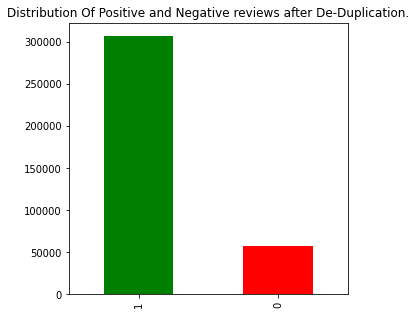

In [26]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [27]:
#Printing some random reviews from the deduplicated dataset.
sent_1 = final_data['Text'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Text'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Text'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Text'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Text'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)

sent_6 = final_data['Text'].values[255600]
print(sent_6)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[255600]))
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.
Review Polarity: Positive
I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.
Review Polarity: Positive
This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.
Review Polarity: Positive
At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My d

In [28]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)
sent_6 = re.sub(r"http\S+", " ", sent_6)

print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)
print(sent_6,"\n")
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful. 

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal. 

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again. 

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results. 

Excellent service, the product arri

In [29]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")
print(removeHtml(sent_6) + "\n")

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.  Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results.

Excellent service, the product arrived on time an

In [30]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [31]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.


In [32]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [33]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

100%|██████████| 70246/70246 [00:00<00:00, 809596.12it/s]


Text(0, 0.5, 'Number of Words')

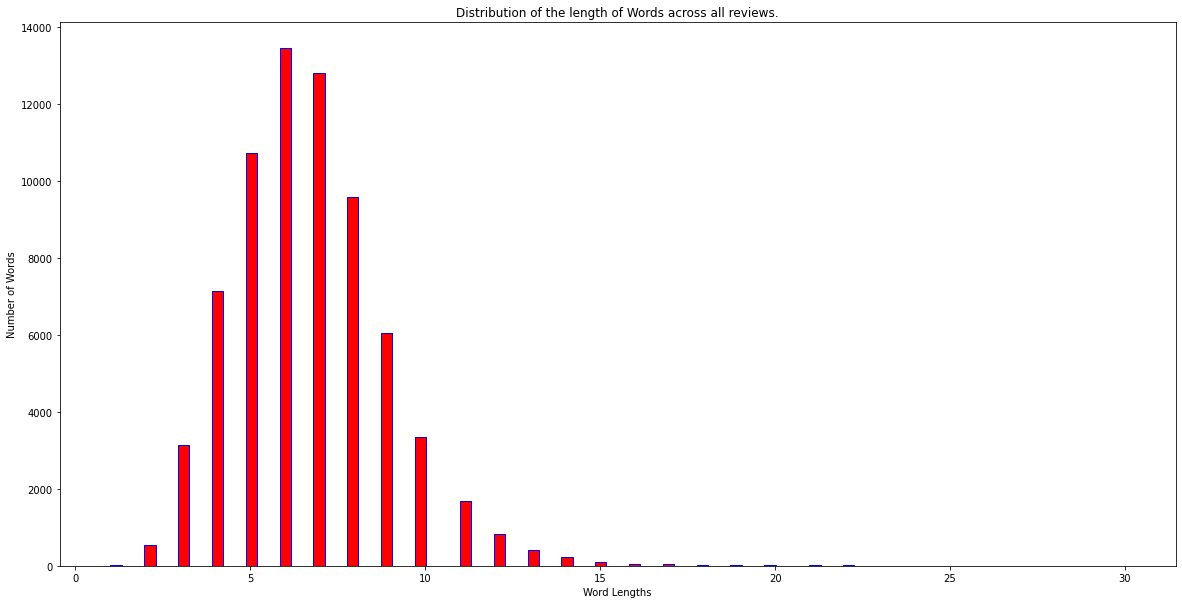

In [34]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
total_words = []

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

<b>Conclusion from the above histogram:</b><br>
We can see that most stemmed words present in the reviews has lengths between 4 and 10. Words which has length greater than 15 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 16.

In [35]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews


100%|██████████| 364171/364171 [09:52<00:00, 614.30it/s]


The length of the data corpus is : 364171


In [36]:
## Similartly you can do preprocessing for summary summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
 
count=0     #Iterator to iterate through the list of summarys and check if a given summary belongs to the positive or negative class
string=' '    
stemed_word=' '

for summary in tqdm(final_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
final_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
final_data['Combined_Reviews'] = final_data['CleanedText'].values + " " + final_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
final_data.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

print("File is saved as 'totally_processed_DB.sqlite'")

100%|██████████| 364171/364171 [00:42<00:00, 8474.01it/s]


File is saved as 'totally_processed_DB.sqlite'


### [4] Featurization

In [37]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite') 
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data into train and test set. The train set will contain 100K old reviews. The test set has 30k newer reviews. We will also use 40K latest reviews as a calibration dataset to calibrate our model. 
X_train = processed_db['CleanedText'].iloc[150000:250000,] ; y_train = processed_db['Class_Labels'].iloc[150000:250000,]
X_test = processed_db['CleanedText'].iloc[250000:280000,] ; y_test = processed_db['Class_Labels'].iloc[250000:280000,]
X_calib = processed_db['CleanedText'].iloc[280000:320000,] ; y_calib = processed_db['Class_Labels'].iloc[280000:320000,]

processed_db.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,CleanedText,CleanedSummary,Combined_Reviews
0,122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1,premium bourbon madagascar vanilla vannila bea...,excel,premium bourbon madagascar vanilla vannila bea...
1,435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0,dabbler enjoy span entir spectrum tast will tr...,god aw,dabbler enjoy span entir spectrum tast will tr...
2,279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1,love faucet husband instal one old hous curren...,love this faucet,love faucet husband instal one old hous curren...
3,279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1,gone treat dinner treat dog work run chanc los...,dog love,gone treat dinner treat dog work run chanc los...
4,466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1,firm favorit breakfast time hous mani year pic...,quaker instant oatmeal dinosaur egg,firm favorit breakfast time hous mani year pic...


<AxesSubplot:title={'center':'Distribution Of Positive and Negative reviews in 150K datapoints.'}>

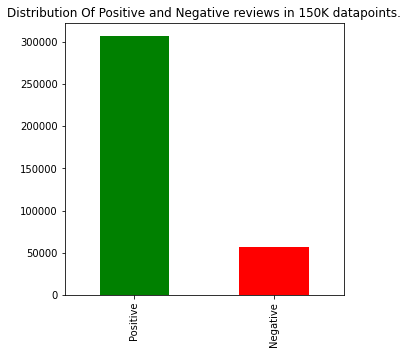

In [38]:
#Display distribution of Postive and Negative reviews.
processed_db["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews in 150K datapoints.',figsize=(5,5))

#### [4.1] BAG OF WORDS

In [39]:
#Initializing the BOW constructor
cv_object = CountVectorizer(min_df=10, max_features=10000, dtype='float').fit(X_train)

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the BOW matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)
X_calib_vectors = cv_object.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BOW vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BOW vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BOW.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BOW.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BOW.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BOW.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BOW.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BOW.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['afford', 'afghanistan', 'aficionado', 'aforement', 'afraid', 'africa', 'african', 'afteral', 'afternoon', 'aftertast']

Creating the BOW vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BOW vectorizer  (100000, 8461)
The shape of our test BOW vectorizer  (30000, 8461)
The number of unique words  8461


#### [4.3] TF-IDF

In [40]:
#Initializing the TF-IDF constructor
tf_idf_obj = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=50000, dtype='float').fit(X_train) #min_df=10: ignore terms that have a document frequency strictly lower than 10.
                                                                                                           #max_features=50000: top 50000 features
#Print names of some random features
print("Some feature names ", tf_idf_obj.get_feature_names()[100:110])
print('='*215)

#Creating the TF-IDF matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TF-IDF vectors using the cleaned corpus...")
X_train_vectors = tf_idf_obj.transform(X_train)
X_test_vectors = tf_idf_obj.transform(X_test)
X_calib_vectors = tf_idf_obj.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words including both unigrams and bigrams. ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['accommod', 'accompani', 'accomplish', 'accord', 'accord box', 'accord direct', 'accord instruct', 'accord label', 'accord packag', 'accord tast']

Creating the TF-IDF vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (100000, 50000)
The shape of our test BiGram vectorizer  (30000, 50000)
The number of unique words including both unigrams and bigrams.  50000


#### [4.4] Word2Vec

In [41]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in processed_db['Combined_Reviews'].values:
    list_of_sentance.append(sentance.split())

In [42]:
w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*215)
print(w2v_model.wv.most_similar('worst'))

[('good', 0.8451541662216187), ('excel', 0.8442205190658569), ('fantast', 0.8389261364936829), ('terrif', 0.8267695903778076), ('awesom', 0.8087078332901001), ('wonder', 0.7442535161972046), ('nice', 0.7122361660003662), ('perfect', 0.7095963358879089), ('decent', 0.6987650990486145), ('fabul', 0.6803072690963745)]
[('nastiest', 0.8928254842758179), ('disgust', 0.7483994960784912), ('nicest', 0.7265369892120361), ('horribl', 0.7246062159538269), ('greatest', 0.715535581111908), ('terribl', 0.7012149095535278), ('best', 0.6781176924705505), ('aw', 0.6768299341201782), ('wors', 0.653335452079773), ('vile', 0.6530884504318237)]


### [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V
#### [4.4.1.1] Avg W2V

In [43]:
#Build a Word2Vec model on train data and use this to vectorize the test and cv data.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, vector_size=200, min_count=5, workers=6) #min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_words = list(word2vec_model.wv.index_to_key)                                       #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in tqdm(word2vec_corpus): #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vectors = vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_test_vectors = vectorize_w2v(X_test, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_w2v(X_calib, word2vec_model, word2vec_words)


print("The shape of our Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)

with open('X_calib_W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

The size of the Word2Vec text corpus :  100000


100%|██████████| 40000/40000 [00:40<00:00, 977.16it/s] 


The shape of our Avg Word2Vec train vectorizer  (100000, 200)
The shape of our Avg Word2Vec test vectorizer  (30000, 200)
The shape of our Avg Word2Vec calibration vectorizer  (40000, 200)


#### [4.4.1.2] TFIDF weighted W2v

In [44]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, vector_size=200, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.index_to_key)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_vectors = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_vectors = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)
                                           
#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

100%|██████████| 40000/40000 [15:55<00:00, 41.88it/s]


The shape of our TF-IDF Avg Word2Vec train vectorizer  (100000, 200)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (30000, 200)
The shape of our TF-IDF Avg Word2Vec calibration vectorizer  (40000, 200)


### [5] Task: Apply Random Forest

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

### Applying RF

This code block contains all the common functions required by both the models, i.e. RF and GBDT.

In [45]:
#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


#This function will display the word cloud for top 50 most important features.
def top_features(trained_clf, vect_object):   
    print("Word Cloud Showing the top 50 most important features.")    
    '''Get the most important features for the given input vector.'''
    features = trained_clf.feature_importances_
    top_features_index = (-features).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_feat = np.take(vect_object.get_feature_names(), top_features_index[:50])
    corpus = " "
    for i in top_feat:
        corpus = corpus + " " + i
    wordcloud = WordCloud(background_color='black',
                          width=800, 
                          height=450)
    wordcloud.generate(corpus)
    fig = plt.figure(1, figsize=(15, 15), facecolor='k')
    plt.axis('off')
    plt.imshow(wordcloud, aspect='equal')
    plt.tight_layout(pad=0)
    plt.show()
    

#Fit this model with the best value of hyperparameter obtained.
def performance(best_clf, vectorizationType, X_train_vec, y_train, X_test_vec, y_test, X_calib_vec, y_calib, max_depth, n_estimators): #optimal_hp should have 2 hyperparameters.
    '''This function is used to measure the various performance metrics of the model. The model is build using the best value
    of hyperparameters, obtained using grid and random search time series based cross validation. '''
    
    print("\n'''PERFORMANCE EVALUATION for {} model '''".format(vectorizationType))
    
    #Initialize the DT model, with the best estimator and fit it onto the train set.
    classifier = best_clf
    classifier.fit(X_train_vec, y_train)

    #Using CalibratedClassifierCV to caliberate the trained classifier.
    calibrated_clf=CalibratedClassifierCV(base_estimator=classifier, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_calib_vec,y_calib)
    
    #Predict the labels for the test set.
    y_pred = calibrated_clf.predict(X_test_vec)
    
    #For computing AUC
    class_probabilities = calibrated_clf.predict_proba(X_test_vec)
    y_probs = class_probabilities[:,1]
    
    #A dictionary which will store the metric values for each model
    metric_info = dict()
    
    #Evaluate the accuracy of the model on test set
    metric_info["Accuracy"] = accuracy_score(y_test, y_pred, normalize=True) * 100 #test_accuracy
    metric_info["Points"] = accuracy_score(y_test, y_pred, normalize=False) #Number of accurate predictions
    metric_info["Precision"] = np.round(metrics.precision_score(y_test ,y_pred),4)
    metric_info["Recall"] = np.round(metrics.recall_score(y_test ,y_pred),4)
    metric_info["F1-score"] = np.round(metrics.f1_score(y_test ,y_pred),4)
    metric_info["AUC"] = np.round(metrics.roc_auc_score(y_test, y_probs),4) #Use probabilities to get a more realistic ROC Curve
    metric_info["Depth"] = max_depth
    metric_info["Estimators"] = n_estimators

    #Display the precision, recall, F1 score and AUC for this model.    
    print('\nThe number of accurate predictions out of {} data points on unseen data {}'.format(X_test_vec.shape[0], metric_info["Points"]))
    print('Accuracy of the {} model on unseen data is {} %'.format(vectorizationType, metric_info["Accuracy"]))
    print("Precision of the {} model on unseen data is {}".format(vectorizationType, metric_info["Precision"]))
    print("Recall of the {} model on unseen data is {}".format(vectorizationType, metric_info["Recall"]))
    print("F1 score of the {} model on unseen data is {}".format(vectorizationType, metric_info["F1-score"]))
    print("AUC of the {} model on unseen data is {}".format(vectorizationType, metric_info["AUC"]))
    
    #Print the classification Report
    print ('\nClasification report ')
    print(metrics.classification_report(y_test,y_pred))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metric_info["Precision"]*100),2))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metric_info["Recall"]*100),2))
    
    #Get the confusion matrix for the running model
    #sciplot.plot_confusion_matrix(y_test ,y_pred)
    cm = metrics.confusion_matrix(y_test ,y_pred)
    
    #Plot confusion matrix using seaborn heatmap.
    import seaborn as sn
    df_cm = pd.DataFrame(cm, index = [' (0)',' (1)'], columns = [' (0)',' (1)'])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')   #fmt='d' for decimal integer.
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title('CONFUSION MATRIX')
    
    #Plot the ROC Curve for both train and test data
    plot_roc(calibrated_clf, X_train_vec, y_train, X_test_vec, y_test)
    
    #Save the below list for later use to display model information
    # Model, HyperParameter Value, Accuracy, AUC, Number of Correct Accurate Predictions 
    info_model_RFGBDT = [vectorizationType, metric_info["Depth"], metric_info["Estimators"], metric_info["Accuracy"], metric_info["AUC"], metric_info["Points"]]
    with open('info_model_RFGBDT.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_RFGBDT)
        filehandle.writelines("\n")
        
    return classifier
   
#This function is used to visualize the results in a 2D plot.    
def plot_auc_2d(param1_val, param2_val, mean_auc_train, mean_auc_cv, results, param_names):
    
    #Sort the AUC scores according to the parameter n_estimators and plot AUC vs n_estimators
    param1_val = [results['params'][i][param_names[0]] for i in range(0,len(results['params']))] #n_estimators
    mean_auc_train_sorted = [i for _,i in sorted(zip(param1_val,mean_auc_train))]
    mean_auc_cv_sorted = [i for _,i in sorted(zip(param1_val,mean_auc_cv))]
    param1_val = sorted(param1_val)
    
    labels=["Train AUC","Test AUC"]
    y_axes = [mean_auc_train_sorted, mean_auc_cv_sorted]
    
    color_map = ['red','green']
    plt.figure(figsize=(10,6))
    for index in range(0,len(labels)):
        plt.plot(param1_val, y_axes[index], color=color_map[index], label=labels[index])
    plt.xlabel('Number of estimators (n_estimators)')
    plt.ylabel('AUC Scores')
    plt.title("Comparison between Train and Cross Validate AUC scores with n_estimators.")
    plt.legend()
    plt.show()
    
    #Sort the AUC scores according to the parameter max_depth and plot AUC vs max_depth
    param2_val = [results['params'][i][param_names[1]] for i in range(0,len(results['params']))] #max_depth
    mean_auc_train_sorted = [i for _,i in sorted(zip(param2_val,mean_auc_train))]
    mean_auc_cv_sorted = [i for _,i in sorted(zip(param2_val,mean_auc_cv))]
    param2_val = sorted(param2_val)
    
    labels=["Train AUC","Test AUC"]
    y_axes = [mean_auc_train_sorted, mean_auc_cv_sorted]
    
    color_map = ['red','green']
    plt.figure(figsize=(10,6))
    for index in range(0,len(labels)):
        plt.plot(param2_val, y_axes[index], color=color_map[index], label=labels[index])
    plt.xlabel('Max Depths (max_depth)')
    plt.ylabel('AUC Scores')
    plt.title("Comparison between Train and Cross Validate AUC scores with max_depth.")
    plt.legend()
    plt.show()
    
    
#Utility function to report best scores, https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
    
#This function is used to obtain the grid values and call other functions to visualize the result of Grid Search.
def plot_results(rsearch_cv):
    '''This function is used to plot the curve for mean squared errors vs alpha values and obtain the optimal 
    value of the hyperparameters'''

    results = rsearch_cv.cv_results_

    #Get the Hyperparameter names in a dictionary
    param_names = []
    for i in results["params"][0].keys():
        param_names.append(str(i))

    param1_val = [results['params'][i][param_names[0]] for i in range(0,len(results['params']))] #max_depth
    param2_val = [results['params'][i][param_names[1]] for i in range(0,len(results['params']))] #min_sample_split

    mean_auc_train =  results['mean_train_score']
    mean_auc_cv =  results['mean_test_score']

    #Get the index position corresponding to the highest AUC score and use it to find the values of best hyperparameters
    index = list(mean_auc_cv).index(max(list(mean_auc_cv)))
    best_param1 = param1_val[index] #n_estimators
    best_param2 = param2_val[index] #max_depth

    print("\nThe best value of hyperparameters are: \n{} = {} \n{} = {}".format(param_names[0],best_param1,param_names[1],best_param2))

    #Compare Train and Test AUC in a 2D graph to determine overfitting and underfitting
    plot_auc_2d(param1_val, param2_val, mean_auc_train, mean_auc_cv, results, param_names)


In [48]:
def get_RandSearchCV_RF(vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and RandomSearchCV, using 10 fold cross validation. '''
    from sklearn.model_selection import TimeSeriesSplit
    from datetime import datetime as dt
    st_t = dt.now()
    tuned_parameters = {'max_depth': [1, 5, 10, 20, 25, 30, 50, 100, 500], 
                         'n_estimators' : [5, 10, 50, 75, 100, 150, 250, 500]}
    cv_timeSeries = TimeSeriesSplit(n_splits=5).split(X_train)
    base_estimator = RandomForestClassifier(criterion='gini', random_state=0) 
    
    #Run randomized search
    n_iter_search = 30
    rsearch_cv = RandomizedSearchCV(base_estimator,
                                    random_state=0,
                                    param_distributions=tuned_parameters, 
                                    n_iter=n_iter_search, 
                                    cv=cv_timeSeries, 
                                    scoring='roc_auc',
                                    return_train_score=True,
                                    n_jobs=-1)
    rsearch_cv.fit(X_train,y_train)
    print("Best estimator obtained from CV data: \n", rsearch_cv.best_estimator_)
    print("Best Score : ", rsearch_cv.best_score_)
    print("Time taken to complete Hyperparameter Search : ",dt.now()-st_t)
    plot_results(rsearch_cv)
    return (rsearch_cv)


def RF_classifier(X_train_vectors, y_train, X_test_vectors, y_test, X_calib_vectors, y_calib, vectorizationType):
    '''This  function will determine the best estimators for each model and use them to call several other functions
    which trains the model and measure the performance of the model and plot the final results etc.'''

    print("\nUSING RandomSearchCV TO DETERMINE THE HYPERPARAMETERS. ")
    print("*****************************************************")
    
    rsearch_cv = get_RandSearchCV_RF(vectorizationType, X_train_vectors, y_train, X_test_vectors, y_test)
    
    print("\nScore Reports with Ranks and STD\n")
    report(rsearch_cv.cv_results_)
    best_estimator = rsearch_cv.best_estimator_
    max_depth = rsearch_cv.best_estimator_.max_depth
    n_estimators = rsearch_cv.best_estimator_.n_estimators
    trained_clf = performance(best_estimator, vectorizationType, X_train_vectors, y_train, X_test_vectors, y_test, X_calib_vectors, y_calib, max_depth, n_estimators)
    return (trained_clf)

#### [5.1] Applying  Random Forests on BOW

Shape of the train data matrix:  (5000, 8461)
Shape of the test data matrix:  (5000, 8461)
Shape of the calibration data matrix:  (5000, 8461)

USING RandomSearchCV TO DETERMINE THE HYPERPARAMETERS. 
*****************************************************
Best estimator obtained from CV data: 
 RandomForestClassifier(max_depth=20, n_estimators=250, random_state=0)
Best Score :  0.8422761871681882
Time taken to complete Hyperparameter Search :  0:01:45.617490

The best value of hyperparameters are: 
n_estimators = 250 
max_depth = 20


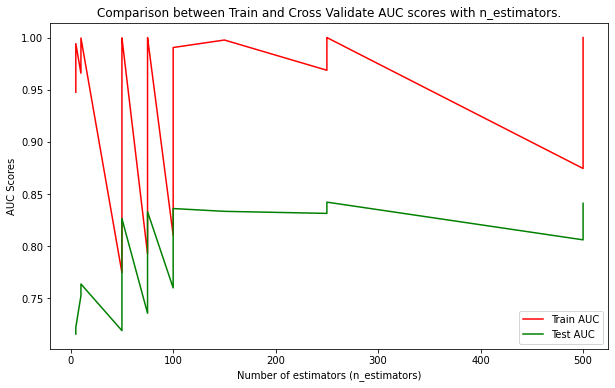

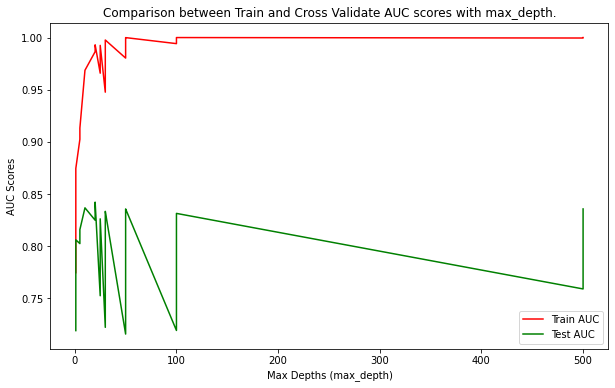


Score Reports with Ranks and STD

Model with rank: 1
Mean validation score: 0.842 (std: 0.051)
Parameters: {'n_estimators': 250, 'max_depth': 20}

Model with rank: 2
Mean validation score: 0.841 (std: 0.050)
Parameters: {'n_estimators': 500, 'max_depth': 20}

Model with rank: 3
Mean validation score: 0.837 (std: 0.051)
Parameters: {'n_estimators': 250, 'max_depth': 10}


'''PERFORMANCE EVALUATION for RF-BOW model '''

The number of accurate predictions out of 5000 data points on unseen data 4403
Accuracy of the RF-BOW model on unseen data is 88.06 %
Precision of the RF-BOW model on unseen data is 0.8906
Recall of the RF-BOW model on unseen data is 0.9781
F1 score of the RF-BOW model on unseen data is 0.9323
AUC of the RF-BOW model on unseen data is 0.8886

Clasification report 
              precision    recall  f1-score   support

           0       0.76      0.37      0.50       799
           1       0.89      0.98      0.93      4201

    accuracy                           0.88   

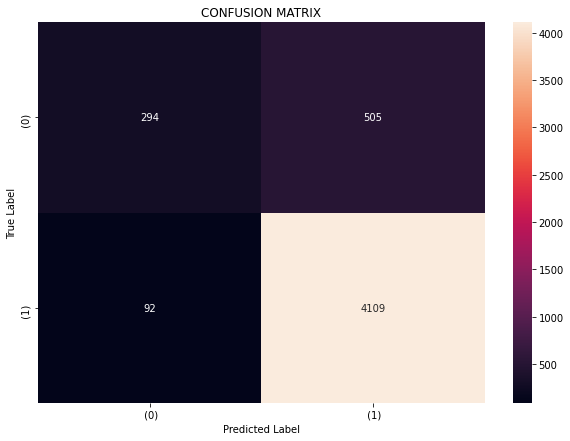

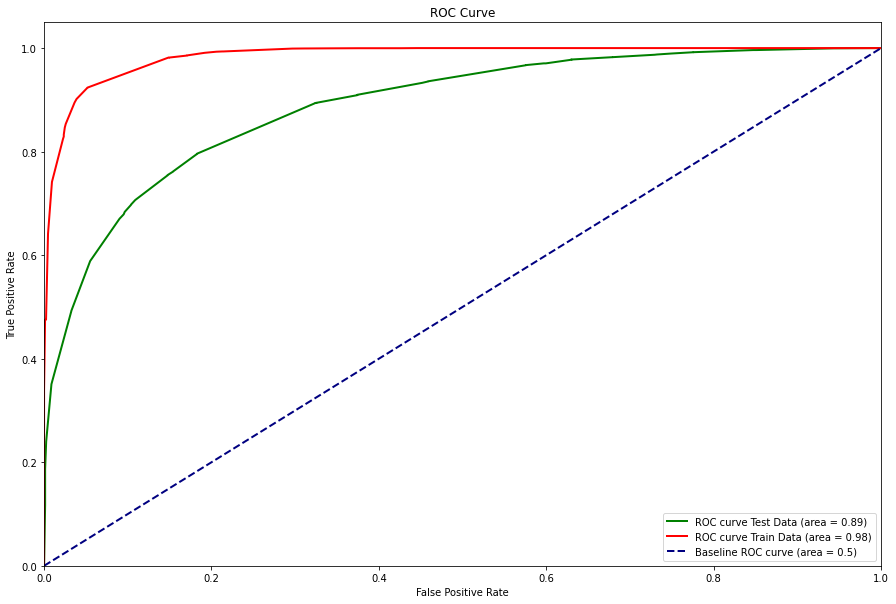

In [49]:
from sklearn.tree import DecisionTreeClassifier

#Load the BOW Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle
from datetime import datetime

with open('X_train_BOW.pkl', 'rb') as file:
    X_train = pickle.load(file)[0:5000]
    
with open('X_test_BOW.pkl', 'rb') as file:
    X_test = pickle.load(file)[0:5000]

with open('y_train_BOW.pkl', 'rb') as file:
    y_train = pickle.load(file)[0:5000]
    
with open('y_test_BOW.pkl', 'rb') as file:
    y_test = pickle.load(file)[0:5000]
    
with open('X_calib_BOW.pkl', 'rb') as file:
    X_calib = pickle.load(file)[0:5000]

with open('y_calib_BOW.pkl', 'rb') as file:
    y_calib = pickle.load(file)[0:5000] 

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_clf_1 = RF_classifier(X_train, y_train, X_test, y_test, X_calib, y_calib, "RF-BOW")

#### [5.1.2] Wordcloud of top 50 important features from

Word Cloud Showing the top 50 most important features.


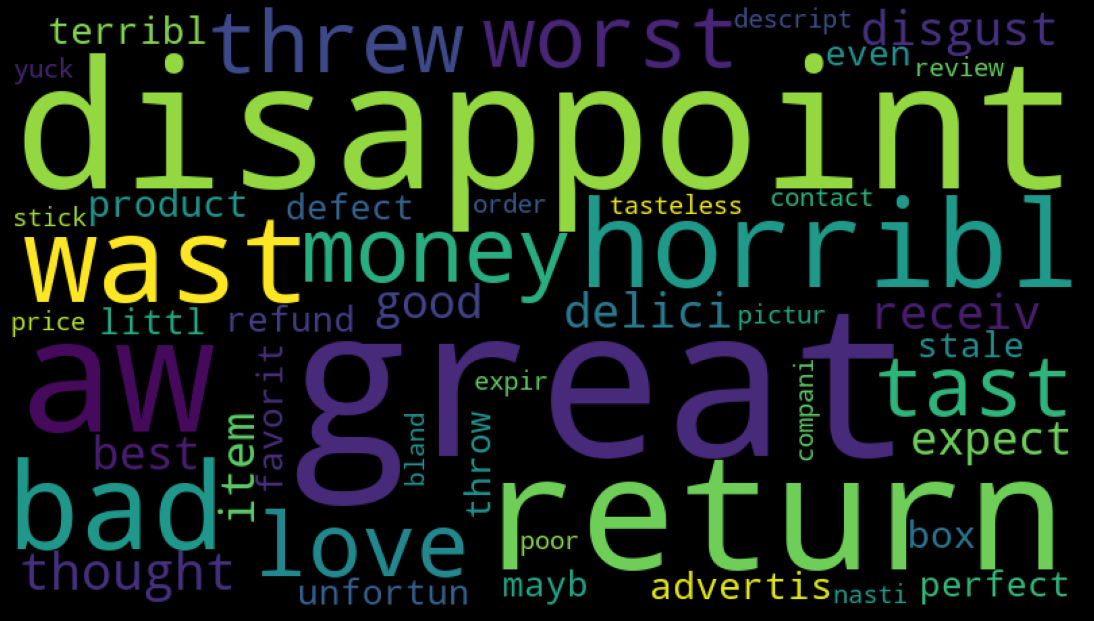

In [50]:
top_features(trained_clf_1, cv_object)

### [5.2] Applying Random Forests on TFIDF

Shape of the train data matrix:  (5000, 50000)
Shape of the test data matrix:  (5000, 50000)
Shape of the calibration data matrix:  (5000, 50000)

USING RandomSearchCV TO DETERMINE THE HYPERPARAMETERS. 
*****************************************************
Best estimator obtained from CV data: 
 RandomForestClassifier(max_depth=50, n_estimators=500, random_state=0)
Best Score :  0.8866374530407711
Time taken to complete Hyperparameter Search :  0:03:32.232218

The best value of hyperparameters are: 
n_estimators = 500 
max_depth = 50


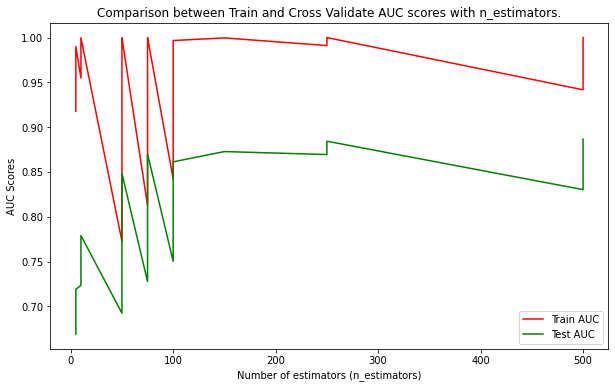

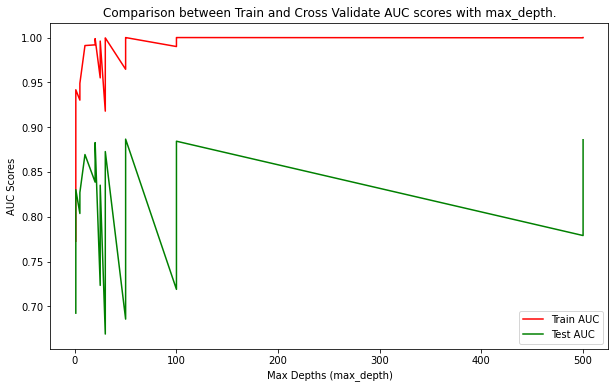


Score Reports with Ranks and STD

Model with rank: 1
Mean validation score: 0.887 (std: 0.040)
Parameters: {'n_estimators': 500, 'max_depth': 50}

Model with rank: 2
Mean validation score: 0.886 (std: 0.036)
Parameters: {'n_estimators': 500, 'max_depth': 500}

Model with rank: 3
Mean validation score: 0.884 (std: 0.037)
Parameters: {'n_estimators': 250, 'max_depth': 100}


'''PERFORMANCE EVALUATION for RF-TFIDF model '''

The number of accurate predictions out of 5000 data points on unseen data 4478
Accuracy of the RF-TFIDF model on unseen data is 89.56 %
Precision of the RF-TFIDF model on unseen data is 0.9163
Recall of the RF-TFIDF model on unseen data is 0.9638
F1 score of the RF-TFIDF model on unseen data is 0.9394
AUC of the RF-TFIDF model on unseen data is 0.9049

Clasification report 
              precision    recall  f1-score   support

           0       0.74      0.54      0.62       799
           1       0.92      0.96      0.94      4201

    accuracy                    

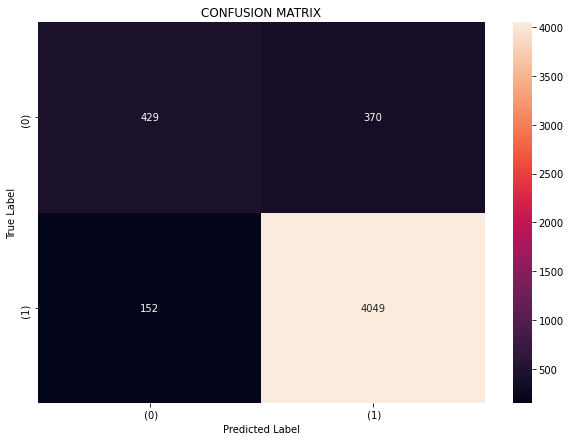

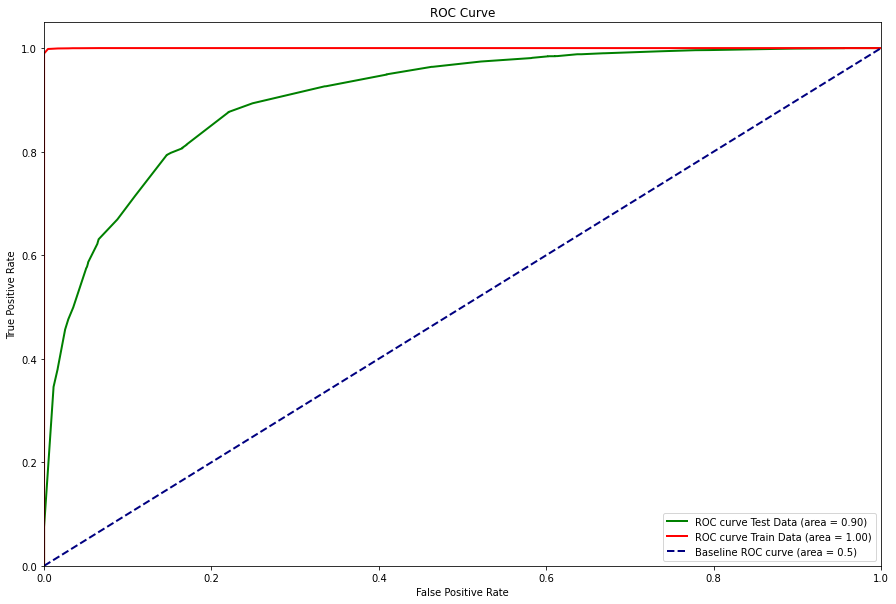

In [51]:
#Load the TF-IDF Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_TFIDF.pkl', 'rb') as file:
    X_train = pickle.load(file)[0:5000]
    
with open('X_test_TFIDF.pkl', 'rb') as file:
    X_test = pickle.load(file)[0:5000]

with open('y_train_TFIDF.pkl', 'rb') as file:
    y_train = pickle.load(file)[0:5000]
    
with open('y_test_TFIDF.pkl', 'rb') as file:
    y_test = pickle.load(file)[0:5000]
    
with open('X_calib_TFIDF.pkl', 'rb') as file:
    X_calib = pickle.load(file)[0:5000]

with open('y_calib_TFIDF.pkl', 'rb') as file:
    y_calib = pickle.load(file)[0:5000]    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_clf_2 = RF_classifier(X_train, y_train, X_test, y_test, X_calib, y_calib, "RF-TFIDF")

#### [5.1.4] Wordcloud of top 20 important features from

Word Cloud Showing the top 50 most important features.


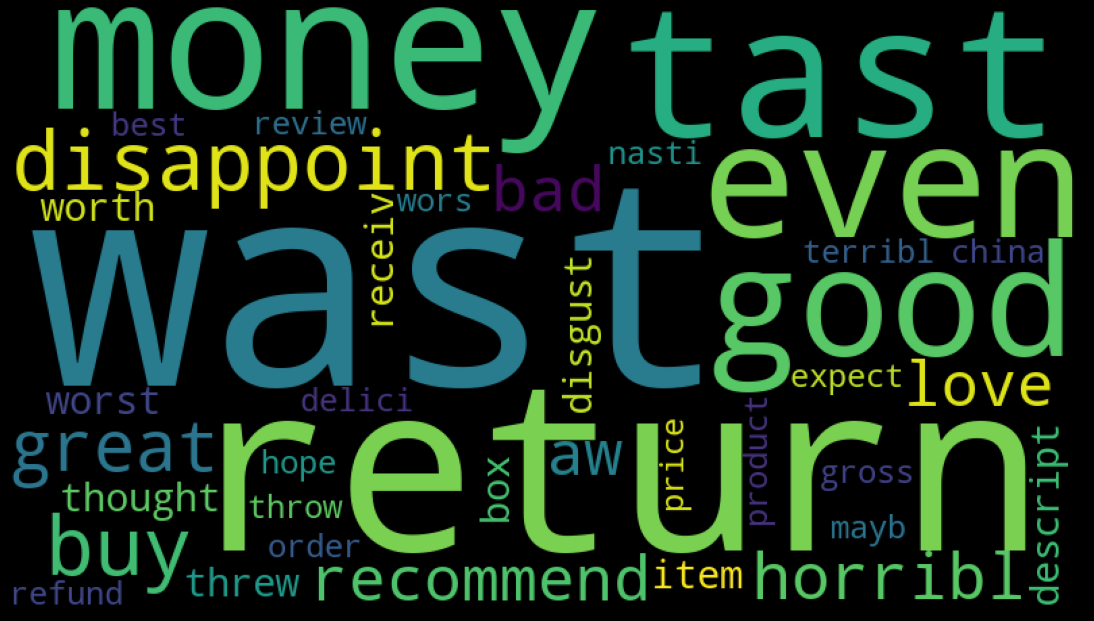

In [52]:
top_features(trained_clf_2, tf_idf_obj)


### [5.3] Applying Random Forests on AVG W2V

Shape of the train data matrix:  (5000, 200)
Shape of the test data matrix:  (5000, 200)
Shape of the calibration data matrix:  (5000, 200)

USING RandomSearchCV TO DETERMINE THE HYPERPARAMETERS. 
*****************************************************
Best estimator obtained from CV data: 
 RandomForestClassifier(max_depth=10, n_estimators=250, random_state=0)
Best Score :  0.890236246861536
Time taken to complete Hyperparameter Search :  0:03:30.073447

The best value of hyperparameters are: 
n_estimators = 250 
max_depth = 10


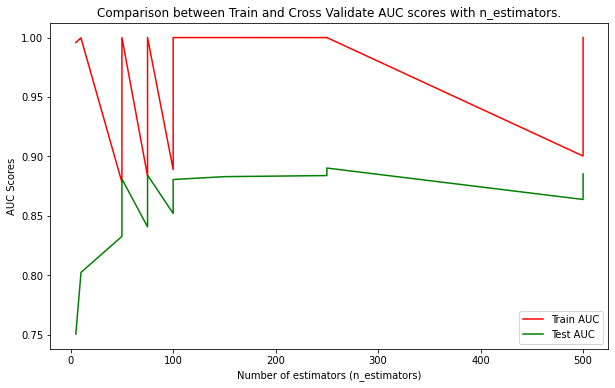

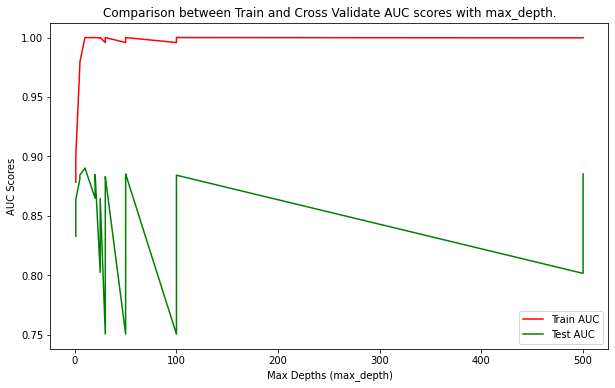


Score Reports with Ranks and STD

Model with rank: 1
Mean validation score: 0.890 (std: 0.014)
Parameters: {'n_estimators': 250, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.885 (std: 0.013)
Parameters: {'n_estimators': 500, 'max_depth': 500}

Model with rank: 2
Mean validation score: 0.885 (std: 0.013)
Parameters: {'n_estimators': 500, 'max_depth': 50}


'''PERFORMANCE EVALUATION for RF-AVG-W2V model '''

The number of accurate predictions out of 5000 data points on unseen data 4398
Accuracy of the RF-AVG-W2V model on unseen data is 87.96000000000001 %
Precision of the RF-AVG-W2V model on unseen data is 0.9016
Recall of the RF-AVG-W2V model on unseen data is 0.9617
F1 score of the RF-AVG-W2V model on unseen data is 0.9307
AUC of the RF-AVG-W2V model on unseen data is 0.8852

Clasification report 
              precision    recall  f1-score   support

           0       0.69      0.45      0.54       799
           1       0.90      0.96      0.93      4201

    accur

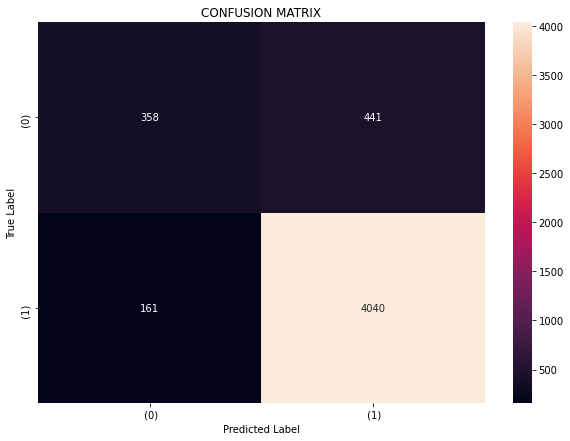

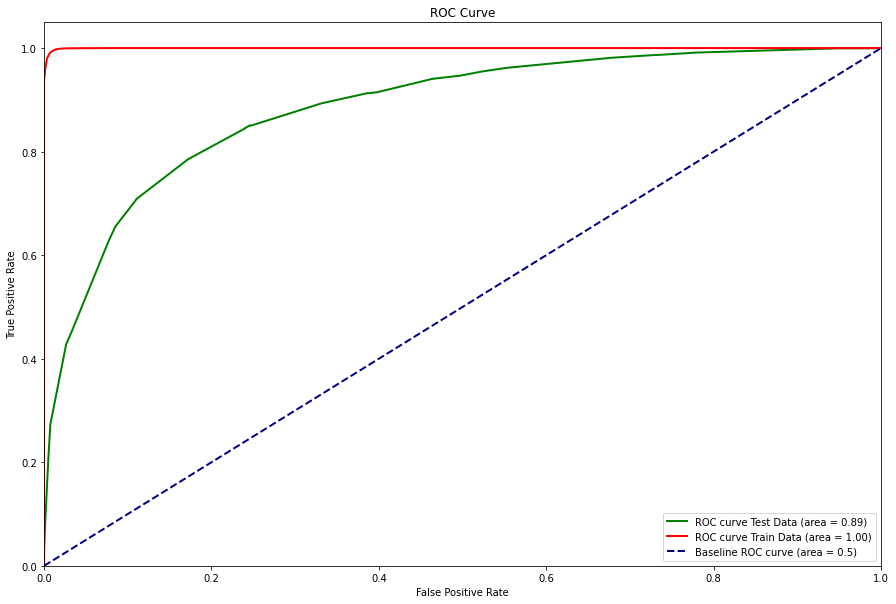

In [53]:
#Load the W2V Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)[0:5000]
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)[0:5000]

with open('y_train_W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)[0:5000]
    
with open('y_test_W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)[0:5000]
    
with open('X_calib_W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)[0:5000]

with open('y_calib_W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)[0:5000]    


print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_clf_3 = RF_classifier(X_train, y_train, X_test, y_test, X_calib, y_calib, "RF-AVG-W2V")

### [5.4] AApplying Random Forests on TFIDF W2V

Shape of the train data matrix:  (5000, 200)
Shape of the test data matrix:  (5000, 200)
Shape of the calibration data matrix:  (5000, 200)

USING RandomSearchCV TO DETERMINE THE HYPERPARAMETERS. 
*****************************************************
Best estimator obtained from CV data: 
 RandomForestClassifier(max_depth=5, n_estimators=75, random_state=0)
Best Score :  0.8418965580867817
Time taken to complete Hyperparameter Search :  0:03:22.925302

The best value of hyperparameters are: 
n_estimators = 75 
max_depth = 5


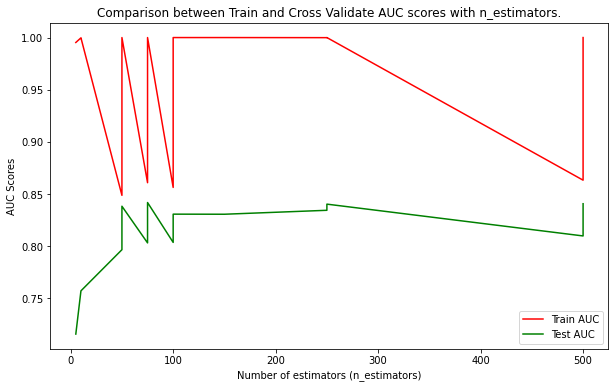

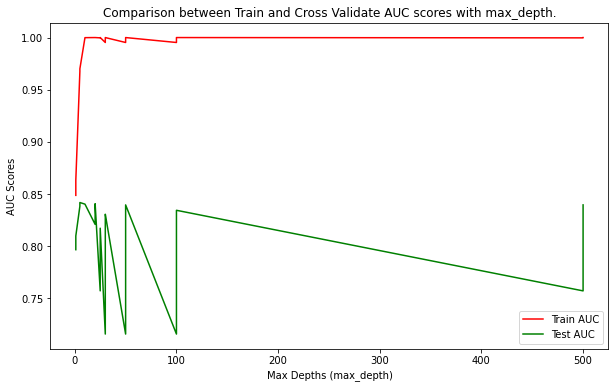


Score Reports with Ranks and STD

Model with rank: 1
Mean validation score: 0.842 (std: 0.017)
Parameters: {'n_estimators': 75, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.841 (std: 0.015)
Parameters: {'n_estimators': 500, 'max_depth': 20}

Model with rank: 3
Mean validation score: 0.840 (std: 0.018)
Parameters: {'n_estimators': 250, 'max_depth': 10}


'''PERFORMANCE EVALUATION for RF-TFIDF-W2V model '''

The number of accurate predictions out of 5000 data points on unseen data 4304
Accuracy of the RF-TFIDF-W2V model on unseen data is 86.08 %
Precision of the RF-TFIDF-W2V model on unseen data is 0.8706
Recall of the RF-TFIDF-W2V model on unseen data is 0.98
F1 score of the RF-TFIDF-W2V model on unseen data is 0.9221
AUC of the RF-TFIDF-W2V model on unseen data is 0.8503

Clasification report 
              precision    recall  f1-score   support

           0       0.69      0.23      0.35       799
           1       0.87      0.98      0.92      4201

    accuracy  

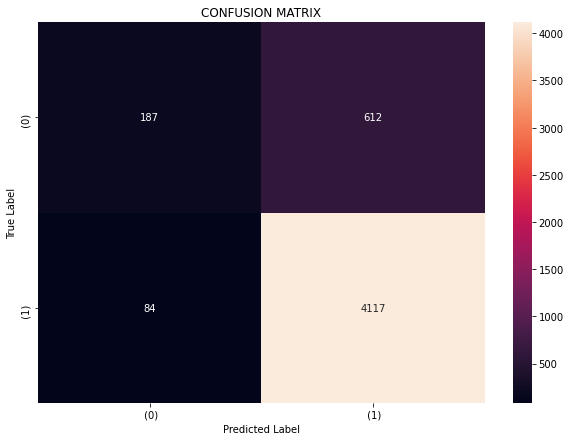

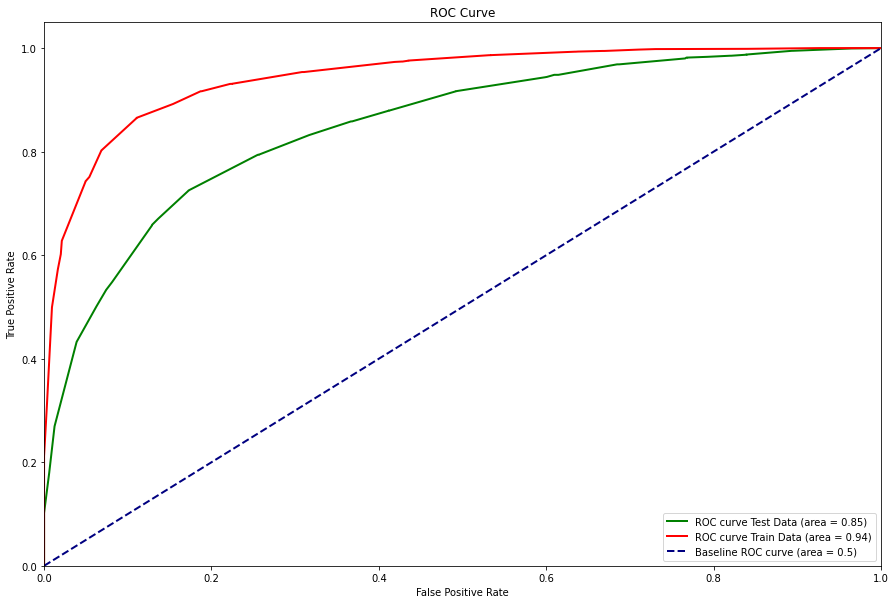

In [54]:
#Load the TF-IDF W2V Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle
    
with open('X_train_TFIDF-W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)[0:5000]
    
with open('X_test_TFIDF-W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)[0:5000]

with open('y_train_TFIDF-W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)[0:5000]
    
with open('y_test_TFIDF-W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)[0:5000]
    
with open('X_calib_TFIDF-W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)[0:5000]

with open('y_calib_TFIDF-W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)[0:5000]   

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_clf_4 = RF_classifier(X_train, y_train, X_test, y_test, X_calib, y_calib, "RF-TFIDF-W2V")


### [6] Conclusions

In [55]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "(Max Depth=)", "Estimators", "Accuracy on Unseen data", "AUC Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_RFGBDT.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+--------------+--------------+------------+-------------------------+-----------+-----------------------------+
|    Model     | (Max Depth=) | Estimators | Accuracy on Unseen data | AUC Score | No. Of accurate predictions |
+--------------+--------------+------------+-------------------------+-----------+-----------------------------+
|    RF-BOW    |      20      |    250     |          88.06          |   0.8886  |             4403            |
|   RF-TFIDF   |      50      |    500     |          89.56          |   0.9049  |             4478            |
|  RF-AVG-W2V  |      10      |    250     |    87.96000000000001    |   0.8852  |             4398            |
| RF-TFIDF-W2V |      5       |     75     |          86.08          |   0.8503  |             4304            |
+--------------+--------------+------------+-------------------------+-----------+-----------------------------+


Here we can notice that our algorithm for Random Forest has worked better for TFIDF representations. In general, throughout the amazon reviews experiment we have observed that the recall for the negative class has been pretty low. Now, this problem can be solved by using a balanced dataset. What this shows is that our model is biased towards postive reviews